In [2]:
# ---------------------------
# Import Libraries
# ---------------------------
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# ---------------------------
# Paths
# ---------------------------
train_dir = r'D:\DS projects\object detection\train'
val_dir = r'D:\DS projects\object detection\val'
test_dir = r'D:\DS projects\object detection\test'

# ---------------------------
# Data Generators
# ---------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # important for correct y_true order
)

print("Class indices:", test_generator.class_indices)  # Check 0=good,1=defective

# ---------------------------
# Build Model
# ---------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze most layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ---------------------------
# Train Model
# ---------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25
)

# ---------------------------
# Evaluate on Test Set
# ---------------------------
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)  # reshape to 1D

y_true = test_generator.classes  # actual labels

print("Unique classes in test set:", np.unique(y_true))  # should be [0,1]

# Binary classification report
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=['Non-defective','Defective']
))

# ---------------------------
# Save Model
# ---------------------------
model.save(r"D:\DS projects\object detection\bottle_defect_model.h5")


Found 231 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 229 images belonging to 2 classes.
Class indices: {'defective': 0, 'good': 1}


C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.6368 - loss: 0.9238 - val_accuracy: 0.5000 - val_loss: 1.1454
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9184 - loss: 0.3098 - val_accuracy: 0.5000 - val_loss: 1.2936
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9096 - loss: 0.3581 - val_accuracy: 0.5000 - val_loss: 1.4274
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9001 - loss: 0.3672 - val_accuracy: 0.5000 - val_loss: 1.5132
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.9121 - loss: 0.3344 - val_accuracy: 0.5000 - val_loss: 1.6017
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.9062 - loss: 0.3269 - val_accuracy: 0.5000 - val_loss: 1.6926
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8871 - loss: 0.3571 - val_accuracy: 0.5000 - val_loss: 1.8878
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8936 - loss: 0.3464 - val_accuracy: 0.5000 - val_loss: 1.9277
Epoch 9/

C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Administrator\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Unique classes in test set: [0 1]
               precision    recall  f1-score   support

Non-defective       0.00      0.00      0.00        20
    Defective       0.91      1.00      0.95       209

     accuracy                           0.91       229
    macro avg       0.46      0.50      0.48       229
 weighted avg       0.83      0.91      0.87       229



In [4]:
import os
os.path.exists(r"D:\DS projects\object detection\bottle_defect_model.h5")


False

Found 231 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 229 images belonging to 2 classes.
Class indices: {'defective': 0, 'good': 1}
Class weights: {0: 5.25, 1: 0.5526315789473685}


C:\Users\Administrator\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6664 - loss: 1.9064 - val_accuracy: 0.5000 - val_loss: 1.0314
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.1300 - loss: 1.5227 - val_accuracy: 0.5000 - val_loss: 1.1756
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7696 - loss: 1.0055 - val_accuracy: 0.5000 - val_loss: 1.1969
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.3259 - loss: 0.8654 - val_accuracy: 0.5000 - val_loss: 1.2077
Epoch 5/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5559 - loss: 0.7704 - val_accuracy: 0.5000 - val_loss: 1.2517
Epoch 6/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7838 - loss: 0.7506 - val_accuracy: 0.5000 - val_loss: 1.3183
Epoch 7/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5295 - loss: 0.6654 - val_accuracy: 0.5000 - val_loss: 1.3835
Epoch 8/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.4899 - loss: 0.6841 - val_accuracy: 0.5000 - val_loss: 1.4579
Epoch 9/

Model saved at: D:\DS projects\object detection\bottle_defect_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Unique classes in test set: [0 1]
               precision    recall  f1-score   support

Non-defective       0.50      0.35      0.41        20
    Defective       0.94      0.97      0.95       209

     accuracy                           0.91       229
    macro avg       0.72      0.66      0.68       229
 weighted avg       0.90      0.91      0.91       229



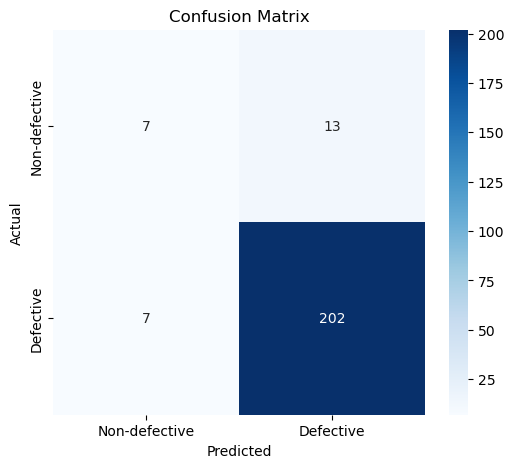

In [6]:
# ---------------------------
# Import Libraries
# ---------------------------
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ---------------------------
# Paths
# ---------------------------
train_dir = r'D:\DS projects\object detection\train'
val_dir = r'D:\DS projects\object detection\val'
test_dir = r'D:\DS projects\object detection\test'
model_path = r'D:\DS projects\object detection\bottle_defect_model.h5'

# ---------------------------
# Data Generators with Augmentation
# ---------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # important for correct y_true order
)

print("Class indices:", test_generator.class_indices)

# ---------------------------
# Compute Class Weights
# ---------------------------
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights_values))
print("Class weights:", class_weights)

# ---------------------------
# Build Model
# ---------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Freeze most layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# ---------------------------
# Train Model with Class Weights
# ---------------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights
)

# ---------------------------
# Save Model
# ---------------------------
model.save(model_path)
print("Model saved at:", model_path)

# ---------------------------
# Evaluate on Test Set
# ---------------------------
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
y_true = test_generator.classes

print("Unique classes in test set:", np.unique(y_true))
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=['Non-defective','Defective'],
    zero_division=0
))

# ---------------------------
# Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-defective','Defective'],
            yticklabels=['Non-defective','Defective'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
